# Track Watch Video Challenge

## Steps Involve to Solve the Problem

 **Step 1. Data Ingestion**
 
        The first step for the deployment of a big data solution would be data ingestion. That is to mention the extraction of data from different sources.In our case study data source is CSV file.
        
**Step 2. Raw Data Store**

        After the data ingestion, the next step would be to store the extracted data. In this case study I have store data into sqlite database.

**Step 3. Data Behaviour Analysis**

        After the raw data store, the next step would be to analysis of data format and behaviour.

**Step 4. Data Modelling logical**
        
         The next step is logical data modelling  to solve the problem and as mentioned in case study I follow star schema data modelling. The data modelling is design using Oracle SQL Modeler.
         
**Step 5. Data Modelling physical**

        The next step is physical data modelling execution on RDBMS.

**Step 6. Data Process**

        This step involve the deployment of a big data solution would be the data processing. The data is then processed through one of the main frameworks for processing such as MapReduce or Spark. But Due to unavailability of this frame work, I am process data using Python pandas and numpy.
        
**Step 7. Data store in Star Schema Tables**
        
        This step involve to store the process data into table of sqlite.
        
**Step 8. Exploratory Data Analysis**
         
         In this step I have used the processed data and do the exploratory data analyis using different python packages such as matplotlib and seaborn.

### Import Libraries

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from datetime import datetime
from io import StringIO

# Data Visulasation package
from matplotlib.colors import LogNorm
from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

##### Connection with sqlite database

In [2]:
conn = sqlite3.connect('VideoRecordRaw.db')  # connect with database
c = conn.cursor() # The database will be saved in the location where your 'py' file is saved

##### Raw data Store in Database

In [3]:
# Create table with the table name VideoWatchedDL append today datetime, it's create table datewise.
watchvideoRawData = "VideoWatchedDL"+ datetime.now().strftime("%Y%m%d_%H%M%S") # Table Name with datetime
file_path = "video_data.csv" # Source Data file path

df = pd.read_csv(file_path,error_bad_lines=False,warn_bad_lines=True) # read csv file from the location
df.to_sql(watchvideoRawData, conn, if_exists="replace",index = False) # Write records stored in a DataFrame to a SQL database.

b'Skipping line 464716: expected 3 fields, saw 4\nSkipping line 464947: expected 3 fields, saw 4\nSkipping line 465187: expected 3 fields, saw 4\nSkipping line 465442: expected 3 fields, saw 4\nSkipping line 465648: expected 3 fields, saw 4\n'


##### Data Record value analysis

In [4]:
allvideoevent = pd.read_sql_query("select * from "+watchvideoRawData, conn) # read the raw data from sql database

In [5]:
# Checking the first value of videotitle |, 
# this will help us in processing part to write match value to create dimension table 

allvideoevent['VideoTitle']= allvideoevent['VideoTitle'].str.split('|').str[0]
allvideoevent['VideoTitle'].unique()

array(['App Web', 'news', 'App iPhone', 'App Android', 'App iPad'],
      dtype=object)

In [6]:
# Checking is there any column contain without | or not

allvideoevent_new = allvideoevent[~allvideoevent['VideoTitle'].str.contains('|')]
allvideoevent_new

,DateTime,VideoTitle,events


##### Logical Data Modelling

Logical Data Model Using oracle data modeler

![LogicalDataModel](LogicalDataModel.png)

Relational Data Model Using oracle data modeler

![RelationalDataModel](RelationalDataModel.png)

##### Physical Data Modelling

In [7]:
# Create table - DimDate with column name date_key,date,hours_Min,Hrs,Min
c.execute('''CREATE TABLE IF NOT EXISTS DimDate
             ([date_key] INTEGER PRIMARY KEY,[Date] date,[hours_Min] text,[Hrs] INTEGER,[Min] INTEGER)''')
          
# Create table - DimPlatform with column name autogenerate platform_id and platformName
c.execute('''CREATE TABLE IF NOT EXISTS DimPlatform
             ([platform_id] INTEGER PRIMARY KEY,[platformName] text)''')
        
# Create table - DimSite with column name autogenerate site_id and siteName
c.execute('''CREATE TABLE IF NOT EXISTS DimSite
             ([site_id] INTEGER PRIMARY KEY, [siteName] text)''')

# Create table - DimVideo with column name autogenerate videotitle_id and videoTitleName
c.execute('''CREATE TABLE IF NOT EXISTS DimVideo
             ([videotitle_id] INTEGER PRIMARY KEY, [videoTitleName] text)''')

# Create table - VideoWatched - Fact Table with column name autogenerate watch_id, date_key, platform_id,
# site_id,videotitle_id and metric
c.execute('''CREATE TABLE IF NOT EXISTS VideoWatched
             ([watch_id] INTEGER PRIMARY KEY, 
             date_key INTEGER references DimDate(date_key),
             platform_id INTEGER references DimPlatform(platform_id),
             site_id INTEGER references DimSite(site_id),
             videotitle_id INTEGER references DimVideo(videotitle_id),
             [metric] text)''')
                                 
conn.commit()

# Note that the syntax to create new tables should only be used once in the code (unless you dropped the table/s at the end of the code). 
# The [*_id] column is used to set an auto-increment ID for each record

##### Data Process

In [8]:
# Read the data from database where “events” not containing “206”
videoevent = pd.read_sql_query("SELECT strftime('%Y%m%d%H%M',DateTime) as date_key, VideoTitle,events from "+watchvideoRawData+" where events not like'%206%'", conn)
videoevent['VideoTitleSeperate']="" # add temp column for process the videotile
videoevent['platformName']="" # add column to store the process platform name
videoevent['siteName']="" # add column to store the process site name
videoevent['videoTitleName']="" # add column to store the videotitle name

In [9]:
videoevent # Display all fetch records

,date_key,VideoTitle,events,VideoTitleSeperate,platformName,siteName,videoTitleName
0,201701110000,App Web|Clips|a-current-affair;2016|William Ty...,"157,120,160,104,162,161,163,164,165,166,171,229",,,,
1,201701110000,news| Shark attacks spearfisherman,"127,157,120,160,104,162,161,163,164,165,166,17...",,,,
2,201701110001,news| Chilean navy films UFO,"157,120,160,104,162,161,170,171,237",,,,
3,201701110000,news| Video shows alleged axe attack at Sydney...,"157,120,160,104,162,161,163,164,165,166,171,229",,,,
4,201701110000,App Web|Clips|today;2017|Pint-sized Aussie sur...,"127,157,120,160,104,162,161,163,164,165,166,17...",,,,
...,...,...,...,...,...,...,...
835539,201701112357,App iPhone|Episode|chicago-med;season-1|Ep 7 S...,"501,508,507,509,121,105,120,160,162,163,164,16...",,,,
835540,201701112332,App iPad|Episode|the-bachelor;season-21|Episode 2,"501,508,507,509,121,105,120,160,162,163,164,16...",,,,
835541,201701112332,App iPad|Episode|the-bachelor;season-21|Episode 2,"501,508,507,509,121,105,120,160,162,163,164,16...",,,,
835542,201701112354,App iPad|Episode|the-bachelor;season-21|Episode 2,"501,508,507,509,121,105,120,160,162,163,164,16...",,,,


In [10]:
dfdimDate = pd.read_sql_query("SELECT * FROM DimDate", conn) # Read records from SQL database to DataFrame.
dfdimPlatform = pd.read_sql_query("SELECT platformName FROM DimPlatform", conn) # Read records from SQL database to DataFrame.
dfdimSite = pd.read_sql_query("SELECT siteName FROM DimSite", conn) # Read records from SQL database to DataFrame.
dfdimVideo = pd.read_sql_query("SELECT videoTitleName FROM DimVideo", conn) # Read records from SQL database to DataFrame.

In [11]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(df2,
                              indicator=True,
                              how='outer')
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df

###### Data process of Dimention Table Plateform

Split VideoTitle by pipe |

If VideoTitle.split(‘|’)[0] contains something that looks like a platform (iPhone, Android Phone etc) then use that as the platform

If VideoTitle.split(‘|’)[0] doesn’t contain a platform but looks like a site, assume the platform is Desktop

If VideoTitle.split(‘|’).count = 1, discard the row.


In [12]:
# Function to convert videotitle to dimension plalteform
def convert_videoTitle_to_dimPlateform(cname):
    if cname[0] == 'App iPhone':
        cname='iPhone'
    elif cname[0] == 'App Android':
        cname='Android Phone'
    elif cname[0] == 'App iPad':
        cname = 'iPad'
    elif len(cname)==1:
        cname = '0'
    else:
        cname='Desktop'
    return cname

In [13]:
# Call function convert_videoTitle_to_dimPlateform with | spilt to extract plateformname
videoevent['VideoTitleSeperate'] = videoevent['VideoTitle'].str.split('|').apply(convert_videoTitle_to_dimPlateform)
videoevent['platformName'] = videoevent[['VideoTitleSeperate']] # Assign value to plateformname column
videoevent.drop(videoevent[videoevent['platformName'] ==0].index, inplace = True) # Drop the row which contain spilt | count ==1
dimPlatform = pd.DataFrame(videoevent['platformName'].drop_duplicates()) # Create a unique value data frame to store in plateform dimention table
# Compate and Find New Record and insert into dimension table
# This logic is implemented for if we run twice in one day then no duplication happen in dimension table
if not dfdimPlatform.empty:
    dimPlatform_diff_df = dataframe_difference(dimPlatform, dfdimPlatform)
    dimPlatform_diff_df.drop(['_merge'],inplace=True,axis=1)
    dimPlatform = dimPlatform_diff_df    
dimPlatform.to_sql('DimPlatform', conn, if_exists='append', index = False) # Write records stored in a DataFrame to a SQL database.

###### Data process of Dimention Table Site

Split VideoTitle by pipe |

If VideoTitle.split(‘|’).count = 1, discard the row.

If VideoTitle.split(‘|’)[0] looks like a site name, save the site name

In [14]:
# Function to convert videotitle to dimension siteName
def convert_videoTitle_to_dimSite(cname):
    if len(cname)==1:
        cname='0'
    elif cname[0] == 'App iPad' or cname[0] == 'App Android' or cname[0] == 'App iPhone':
        cname='NotSite'
    else:
        cname = cname[0]
    return cname

In [15]:
# Call function convert_videoTitle_to_dimPlateform with | spilt to extract site name
videoevent['VideoTitleSeperate'] = videoevent['VideoTitle'].str.split('|').apply(convert_videoTitle_to_dimSite)
videoevent['siteName'] = videoevent[['VideoTitleSeperate']] # Assign value to plateformname column
videoevent.drop(videoevent[videoevent['siteName'] ==0].index, inplace = True) # Drop the row which contain spilt | count ==1
dimSite = pd.DataFrame(videoevent['siteName'].drop_duplicates()) # Create a unique value data frame to store in site dimention table
# Compate and Find New Record and insert into dimension table
# This logic is implemented for if we run twice in one day then no duplication happen in dimension table
if not dfdimPlatform.empty:
    dimSite_diff_df = dataframe_difference(dimSite, dfdimSite)
    dimSite_diff_df.drop(['_merge'],inplace=True,axis=1)
    dimSite = dimSite_diff_df   
dimSite.to_sql('DimSite', conn, if_exists='append', index = False) # Write records stored in a DataFrame to a SQL database.

###### Data process of Dimention Table Video Title Name

Last piece of VideoTitle.split(‘|’) contains the video title

You can ignore any middle pieces

In [16]:
# Function to convert videotitle to dimension videotitle
def convert_videoTitle_to_dimVideo(cname):
    
    return cname[1]

In [17]:
# Call function convert_videoTitle_to_dimPlateform with | reverse spilt to extract video title name
videoevent['VideoTitleSeperate'] = videoevent['VideoTitle'].str.rsplit('|', 1).apply(convert_videoTitle_to_dimVideo)
videoevent['videoTitleName'] = videoevent[['VideoTitleSeperate']] # Assign value to plateformname column
dimVideo = pd.DataFrame(videoevent['videoTitleName'].drop_duplicates()) # Create a unique value data frame to store in video dimention table
# Compate and Find New Record and insert into dimension table
# This logic is implemented for if we run twice in one day then no duplication happen in dimension table
if not dfdimPlatform.empty:
    dimVideo_diff_df = dataframe_difference(dimVideo, dfdimVideo)
    dimVideo_diff_df.drop(['_merge'],inplace=True,axis=1)
    dimVideo = dimVideo_diff_df
dimVideo.to_sql('DimVideo', conn, if_exists='append', index = False) # Write records stored in a DataFrame to a SQL database.

###### Data process of Dimention Table Date 

In [18]:
# Read the data from database where “events” not containing “206” and convert the datetime into datekey, date, hrs and minutes
dimDate = pd.read_sql_query("SELECT distinct strftime('%Y%m%d%H%M',DateTime) as date_key, strftime('%Y-%m-%d',DateTime) as Date,strftime('%H:%M',DateTime) as hours_Min,strftime('%H',DateTime) as Hrs,strftime('%M',DateTime) as Min from "+watchvideoRawData+" where events not like'%206%' and strftime('%Y%m%d%H%M',DateTime) not in(select date_key from DimDate)  order by DateTime asc", conn)
dimDate.to_sql('DimDate', conn, if_exists='append', index = False) # Write records stored in a DataFrame to a SQL database.

###### Data Process and Store in Fact Table

In [19]:
tbl_dimDate = pd.read_sql_query("SELECT * FROM DimDate", conn) # Read records from SQL database to DataFrame.
tbl_dimPlatform = pd.read_sql_query("SELECT * FROM DimPlatform", conn) # Read records from SQL database to DataFrame.
tbl_dimSite = pd.read_sql_query("SELECT * FROM DimSite", conn) # Read records from SQL database to DataFrame.
tbl_dimVideo = pd.read_sql_query("SELECT * FROM DimVideo", conn) # Read records from SQL database to DataFrame.
tbl_VideoWatched = pd.read_sql_query("SELECT SUBSTR(date_key, 1, 8) as date_key FROM VideoWatched limit 1", conn)

In [20]:
videoevent.drop(['VideoTitleSeperate','VideoTitle'], axis = 1, inplace = True) # Drop unnecessary/ unused columns

In [21]:
# Left join with dimention of plateform table on column platformName and assign it plateform Id value in Fact table frame
videoevent = videoevent.merge(tbl_dimPlatform,on='platformName',how="left")
videoevent.drop(['platformName'],inplace=True,axis=1) # Drop unused plateformName columns because it's Id value written into dataframe

In [22]:
# Left join with dimention of site table on column siteName and assign it site Id value in Fact table frame
videoevent = videoevent.merge(tbl_dimSite,on='siteName',how="left")
videoevent.drop(['siteName'],inplace=True,axis=1) # Drop unused siteName columns because it's Id value written into dataframe

In [23]:
# Left join with dimention of video table on column videotitleName and assign it videotitle Id value in Fact table frame
videoevent = videoevent.merge(tbl_dimVideo,on='videoTitleName',how="left")
videoevent.drop(['videoTitleName'],inplace=True,axis=1) # Drop unused videotTitleName columns because it's Id value written into dataframe

In [24]:
videoevent.rename(columns={'events':'metric'},inplace=True) # Rename the event column into metric
videoevent = videoevent.reindex(columns=['date_key','platform_id','site_id','videotitle_id','metric']) # Re-indexing of pandas frame

Store value into Fact Table

In [25]:
# If fact table is empty then insert the record and if fact table is not empty and in single day run etl flow twice
# then avoid the duplication
date_df =''
date_tbl=''
if not tbl_VideoWatched.empty:
    date_df = videoevent['date_key'].str[:8][0]
    date_tbl = tbl_VideoWatched['date_key'].str[:8][0]
    
if (tbl_VideoWatched.empty) or (date_df != date_tbl):
    videoevent.to_sql('VideoWatched', conn, if_exists='append', index = False) # Write records stored in a DataFrame to a SQL database Fact Table.

In [26]:
# Execute the DROP Table SQL statement

dropTable = "DROP TABLE "+watchvideoRawData

c.execute(dropTable)

The source data table need to be delete because the datawarehouse only keep dimension and fact table. In this case we create temporary table to store this source data in sqlite for data process purpose. But, In real scenarios of the data pipeline we need to store this data into data lake and then need to processs and lastly, dump the records in datawarehouse star schema tables.

### Exploratory Data Analysis

In [27]:
# Read records from SQL database to DataFrame for explorattory data analysis

watchedVideoEvent=pd.read_sql_query("select vw.watch_id as watchID,dd.Date as Date,dd.hours_Min as Hrs_Min,dd.Hrs as Hours,dd.Min as Minutes, dp.platformName as platformName, ds.siteName as siteName,dv.videoTitleName as videoTitleName, vw.metric as events from VideoWatched vw"+
" inner join  DimDate dd on dd.date_key =vw.date_key " +
" inner join  DimPlatform dp on dp.platform_id =vw.platform_id " +
" inner join  DimSite ds on ds.site_id =vw.site_id " +
" inner join  DimVideo dv on dv.videotitle_id =vw.videotitle_id", conn)

watchedVideoEvent

,watchID,Date,Hrs_Min,Hours,Minutes,platformName,siteName,videoTitleName,events
0,1,2017-01-11,00:00,0,0,Desktop,App Web,William Tyrrell twist,"157,120,160,104,162,161,163,164,165,166,171,229"
1,2,2017-01-11,00:00,0,0,Desktop,news,Shark attacks spearfisherman,"127,157,120,160,104,162,161,163,164,165,166,17..."
2,3,2017-01-11,00:01,0,1,Desktop,news,Chilean navy films UFO,"157,120,160,104,162,161,170,171,237"
3,4,2017-01-11,00:00,0,0,Desktop,news,Video shows alleged axe attack at Sydney serv...,"157,120,160,104,162,161,163,164,165,166,171,229"
4,5,2017-01-11,00:00,0,0,Desktop,App Web,Pint-sized Aussie surfer hits the global stage,"127,157,120,160,104,162,161,163,164,165,166,17..."
...,...,...,...,...,...,...,...,...,...
835539,835540,2017-01-11,23:57,23,57,iPhone,NotSite,Ep 7 Saints,"501,508,507,509,121,105,120,160,162,163,164,16..."
835540,835541,2017-01-11,23:32,23,32,iPad,NotSite,Episode 2,"501,508,507,509,121,105,120,160,162,163,164,16..."
835541,835542,2017-01-11,23:32,23,32,iPad,NotSite,Episode 2,"501,508,507,509,121,105,120,160,162,163,164,16..."
835542,835543,2017-01-11,23:54,23,54,iPad,NotSite,Episode 2,"501,508,507,509,121,105,120,160,162,163,164,16..."


##### Popular platforms Distribution

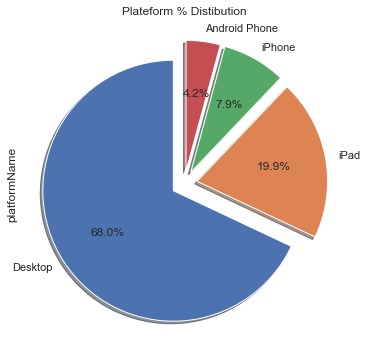

In [28]:
watchedVideoEvent['platformName'].value_counts().plot.pie( title="Plateform % Distibution",figsize=(6,6),
            explode = (0.1, 0.1, 0.1, 0.1)   ,autopct='%1.1f%%',shadow=True, startangle=90)

As per the pie chart above, It's clearly shows that more than 68% video watch on Desktop Plateform followed by iPad 19%,iPhone 8% and Android 4%. Most of the people prefer the watch online video on desktop or laptop in browser.

##### Visit Site Bar Chart

Text(0.5, 1.0, 'Number of Users that Visit the Site')

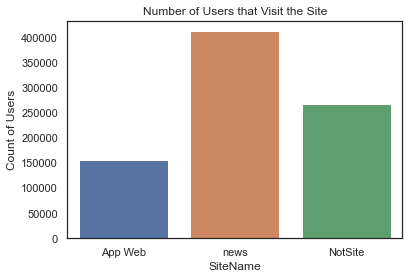

In [29]:
# Seaborn count plot for SiteName column
sns.countplot(x='siteName', data=watchedVideoEvent)
# Set the Xlabel on graph
plt.xlabel('SiteName')
# Set the Ylabel on graph
plt.ylabel('Count of Users')
# Set the title on graph
plt.title('Number of Users that Visit the Site')

The above bar chart shown that most of people open the site watch the videos regarding to the news. More than 400000 news videos watch by community followed by other video on web and mobile devices.

##### Popluar Videos Title

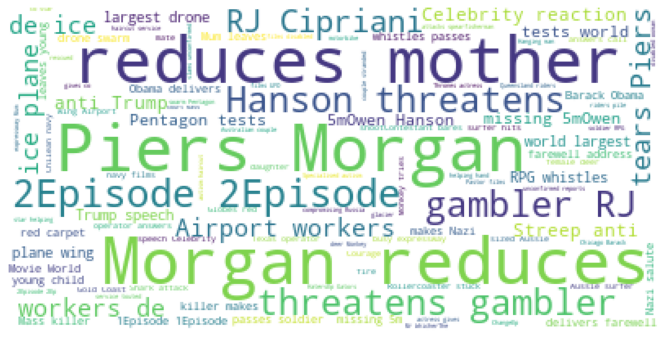

In [30]:
# Create the text string of videotitle name
si=StringIO() # initialize String IO 
watchedVideoEvent['videoTitleName'].apply(lambda x: si.write(str(x))) # concate all the dataframe rows into single text string
s=si.getvalue() # get the convert single string text value
si.close() # close String IO

# Read the whole text.
text = s

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18,6)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(s),max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() # shows the wordcloud plot

As per display in word of cloud, it inferred that most populer video watch by people is Episode2, Mother,Piers,Morgan etc. 

##### Favorite timing of video watch

Text(0.5, 1.0, 'Timing of video watch')

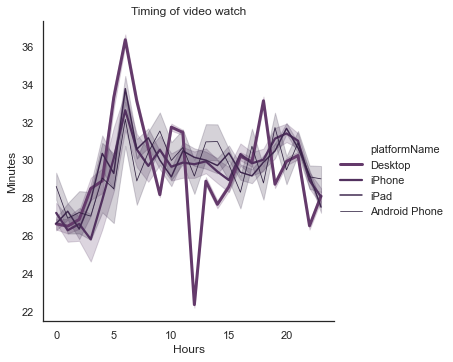

In [31]:
palette = sns.cubehelix_palette(light=.3, n_colors=4)
sns.relplot(x="Hours", y="Minutes",
           hue="platformName", size="platformName",
           palette=palette,
           kind="line", data=watchedVideoEvent)
plt.title('Timing of video watch')

As shown in the relation line plot, It's clearly visible that most of the people watch video on all plateform in morning time between 5:30 AM to 7:30 AM, and 6:30 AM morning most video watch by people. Also, at 10:30 AM very low number of people have watched the video. This chart helpful to get the information about the people different faviourte timing to watching videos. Moreover, majorly video watched by people in morning time.

##### Date Vise Favorite timing of video watch

Text(0.5, 1.0, 'Date Vise Timing of video watch')

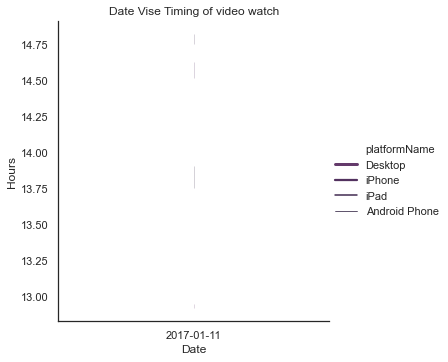

In [32]:
palette = sns.cubehelix_palette(light=.3, n_colors=4)
sns.relplot(x="Date", y="Hours",
           hue="platformName", size="platformName",
           palette=palette,
           kind="line", data=watchedVideoEvent)
plt.title('Date Vise Timing of video watch')

This relation line chart give the information about date vise video watching time with used platfrom. Currently, only having the single date value 2017-01-11.

##### Timing of Site open

Text(0.5, 1.0, 'Timing of Site Open')

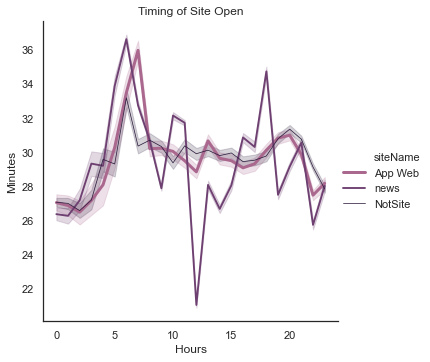

In [33]:
palette = sns.cubehelix_palette(light=.5, n_colors=3)
sns.relplot(x="Hours", y="Minutes",
           hue="siteName", size="siteName",
           palette=palette,
           kind="line", data=watchedVideoEvent)
plt.title('Timing of Site Open')

As shown in the relation line plot, It's clearly visible that most of the people open the news site on all plateform in morning time between 5:30 AM to 7:30 AM, and 6:30 AM morning news video watch by people. Also, at 10:30 AM very low number of people have watched the video. This chart helpful to get the information about the people different faviourte timing to open the site and watch videos. Moreover, maximun news site open by people in morning time.

##### Total time spend to watch Video on Different Plateform

Text(0.5, 1.0, 'Flow from Plateform to VideoTitle, Total Hours')

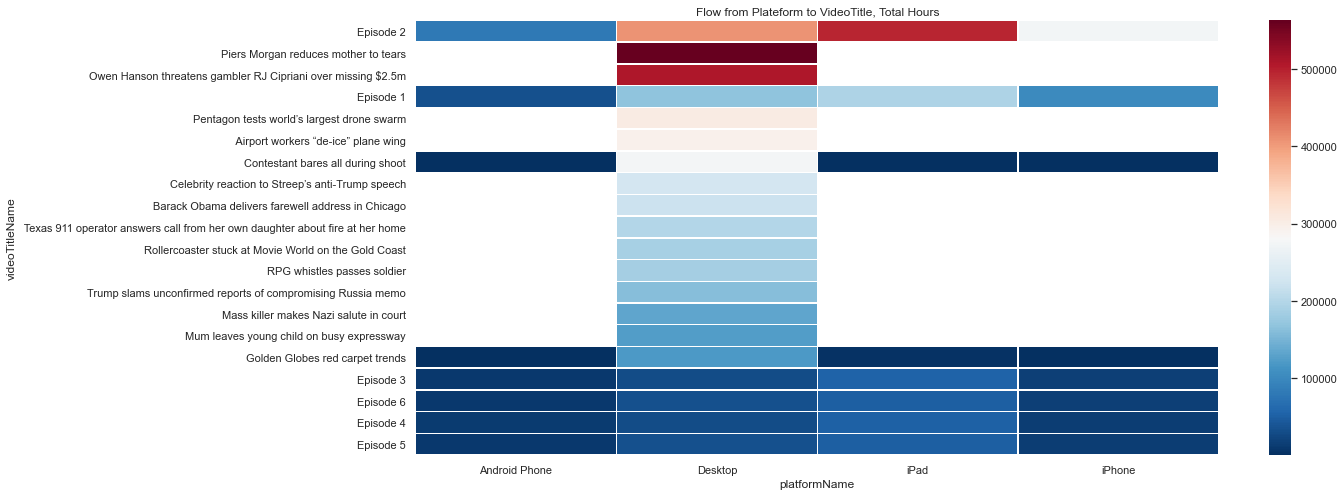

In [34]:
# Select the columns for heat map flow
flow = pd.crosstab(    
    watchedVideoEvent['videoTitleName'],
    watchedVideoEvent['platformName'],
    watchedVideoEvent['Hours'],aggfunc='sum' # we can change this agg funcation to get various information
)
# Skip row with row label
flow['tot'] = flow.sum(axis=1)
# Sort the value of row label
flow = flow.sort_values('tot', ascending=False)
flow = flow.drop('tot', axis=1)
# set the plot figure size
fig, ax = plt.subplots(figsize=[18,8])
# Display the seaborn heat map of videoTitleName,platformName and Hours
sns.heatmap(flow.head(20), cmap='RdBu_r', linewidths=.5)
# Set the title on graph
ax.set_title('Flow from Plateform to VideoTitle, Total Hours')

This heat map give the information about the total number of time spend for each video watch on different platform. As per the shown in heat map, higest time spend on episode2 on iPad.

##### Number of watch Video on Different Plateform

Text(0.5, 1.0, 'Flow from Plateform to VideoTitle, Count Video')

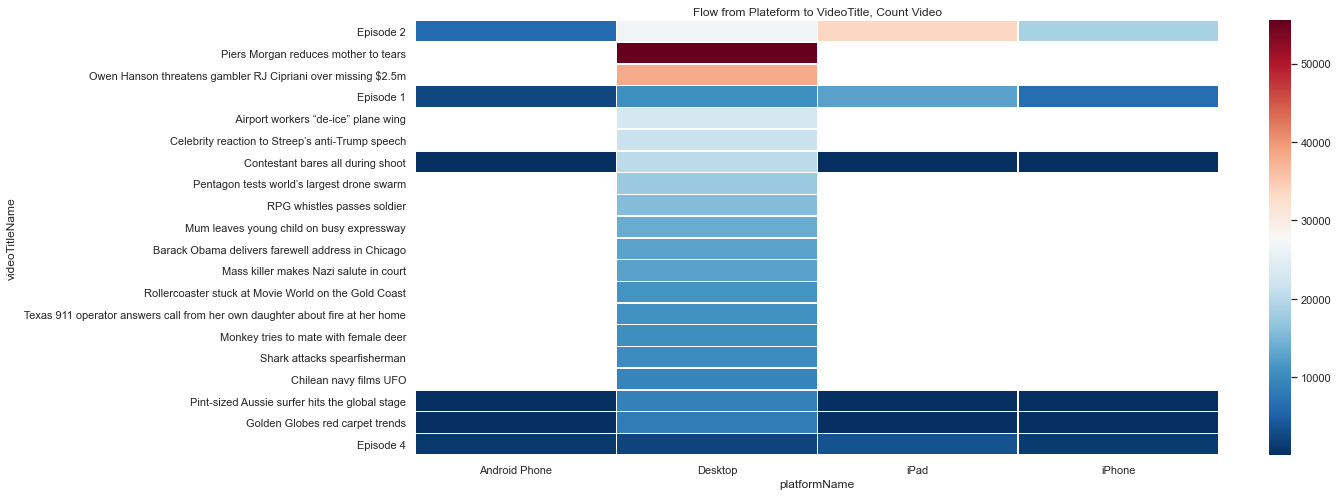

In [35]:
# Select the columns for heat map flow
flow = pd.crosstab(    
    watchedVideoEvent['videoTitleName'],
    watchedVideoEvent['platformName'],
    watchedVideoEvent['Minutes'],aggfunc='count'
)
# Skip row with row label
flow['tot'] = flow.sum(axis=1)
# Sort the value of row label
flow = flow.sort_values('tot', ascending=False)
flow = flow.drop('tot', axis=1)
# set the plot figure size
fig, ax = plt.subplots(figsize=[18,8])
# Display the seaborn heat map of videoTitleName,platformName and Minutes
sns.heatmap(flow.head(20), cmap='RdBu_r', linewidths=.5)
# Set the title on graph
ax.set_title('Flow from Plateform to VideoTitle, Count Video')

This heat map give the information about the count of each video watch on different platform. As per the shown in heat map, higest time spend on Piers Morgan reduce mother to tears on Desktop.

##### Total time spend on Video Watching

Text(0.5, 1.0, 'Flow from Hours to VideoTitle, Total time')

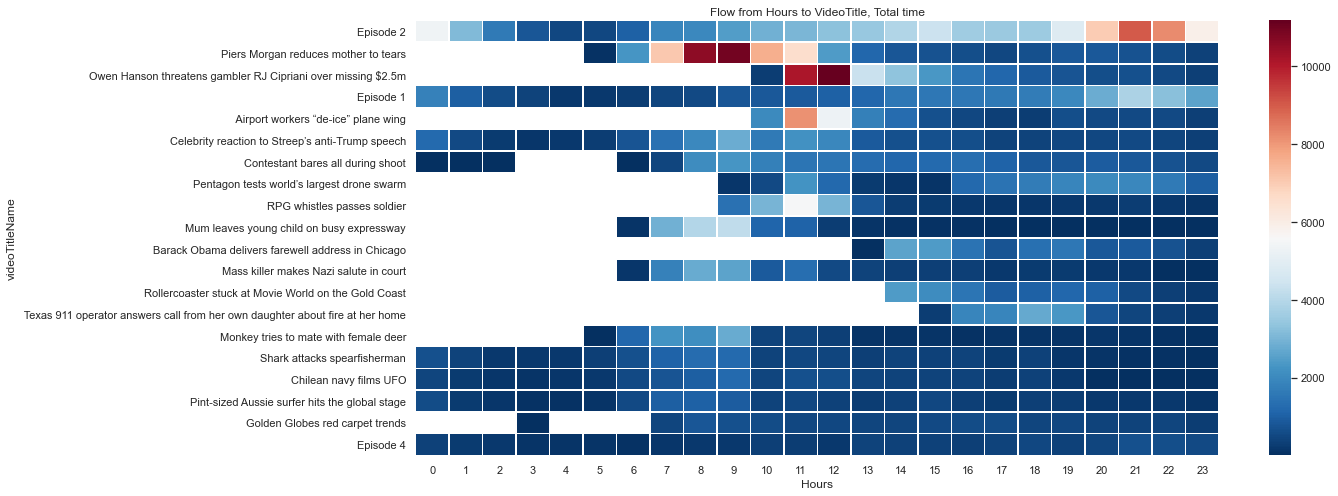

In [36]:
# Select the columns for heat map flow
flow = pd.crosstab(    
    watchedVideoEvent['videoTitleName'],
    watchedVideoEvent['Hours'],
    watchedVideoEvent['Minutes'],aggfunc='count'
)
# Skip row with row label
flow['tot'] = flow.sum(axis=1)
# Sort the value of row label
flow = flow.sort_values('tot', ascending=False)
flow = flow.drop('tot', axis=1)
# set the plot figure size
fig, ax = plt.subplots(figsize=[18,8])
# Display the seaborn heat map of videoTitleName, Hours and Minutes
sns.heatmap(flow.head(20), cmap='RdBu_r', linewidths=.5)
# Set the title on graph
ax.set_title('Flow from Hours to VideoTitle, Total time')

This chart give the information about which video is more watch on what time of the day. AS shown in the heat map, Episode2 watched in maximun in night timing after 8 PM every day. Also, Piers Morgan reduce mother to tears shows majorly watch in morning time between 7 AM to 11 AM. 

#### Date Vise Video Popularity 

Text(0.5, 1.0, 'Flow from Date to Video Title, Popularity')

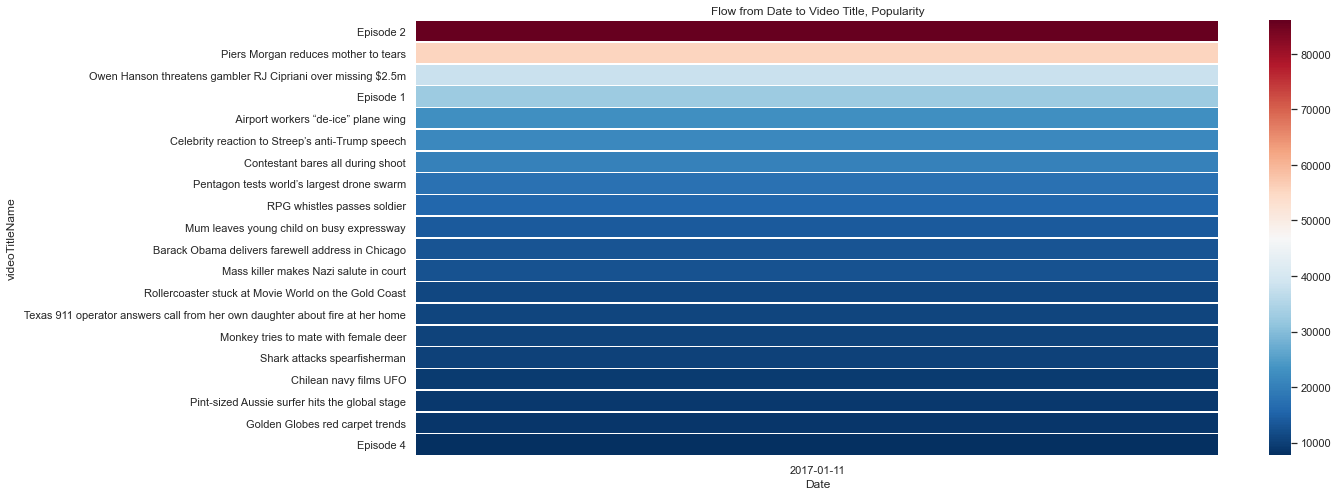

In [37]:
# Select the columns for heat map flow
flow = pd.crosstab(    
    watchedVideoEvent['videoTitleName'],
    watchedVideoEvent['Date'],
    watchedVideoEvent['Hours'],aggfunc='count'
)
# Skip row with row label
flow['tot'] = flow.sum(axis=1)
# Sort the value of row label
flow = flow.sort_values('tot', ascending=False)
flow = flow.drop('tot', axis=1)
# set the plot figure size
fig, ax = plt.subplots(figsize=[18,8])
# Display the seaborn heat map of videoTitleName, Date and Hours
sns.heatmap(flow.head(20), cmap='RdBu_r', linewidths=.5)
# Set the title on graph
ax.set_title('Flow from Date to Video Title, Popularity')

This heatmap give the information about the popularity of each video date vise. As per the given data currently only single date records is present 2017-01-11 and most popular video is Episode 2.

In [38]:
# Close the connection object

conn.close()